# Fanal, a neutrino-less beta decay experiment 

## An open exercise

### Signal Estimation from data - Fitting

#### USC, Master de Física, Física de Partículas II


J. A. Hernando-Morata, with the help of J. Muñoz, J. M. Benlloch, B. Palmeiro, G. Díaz.

February 2021

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants
import scipy.stats     as stats
import scipy.optimize  as optimize

import warnings
warnings.filterwarnings('ignore')

In [3]:
# REMEMBER TO ADD your Fanal FOLDER TO PYTHONPATH
import os
import sys
dirpath = os.getcwd()[:-9]
print('add path to PYTHONPATH : ', dirpath)
sys.path.insert(0, os.path.abspath(dirpath))

add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal


In [4]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.efit    as efit     # Fit Utilites - Includes Extend Likelihood Fit with composite PDFs
import core.utils   as ut       # generic utilities
import ana.fanal    as fn       # analysis functions specific to fanal
import ana.collpars as collpars # collaboration specific parameters
pltext.style()

## Indications

### Goal

  **Estimate the number of signal events in data. Estimate the half-life value**.

### Indications

   * Get the data
   
   * Estimate the number of signal events (with the method validated in the previous notebook)
   
   * Measure the half-life.
   
   * Estimate also the uncertainties.


## Main Parameters

In [5]:
coll   = 'test_alpha'
erange = fn.erange
eroi   = fn.eroi 
eblob2 = fn.eblob2

print('Data From               : {:s}'.format(coll))
print('Energy range            : ({:6.3f}, {:6.3f}) MeV'.format(*erange))
print('Blob-2 energy threshold : {:6.3f} MeV'.format(eblob2))
print('Energy RoI range        : ({:6.3f}, {:6.3f}) MeV'.format(*eroi))

Data From               : test_alpha
Energy range            : ( 2.400,  2.700) MeV
Blob-2 energy threshold :  0.400 MeV
Energy RoI range        : ( 2.430,  2.480) MeV


In [6]:
from ana.collpars import nevts_Bi_RoI, nevts_Tl_RoI

print('Number Bi events in RoI = {:6.3f} +- {:6.3f}'.format(*nevts_Bi_RoI))
print('Number Tl events in RoI = {:6.3f} +- {:6.3f}'.format(*nevts_Tl_RoI))

Number Bi events in RoI =  2.290 +-  0.232
Number Tl events in RoI =  0.220 +-  0.003


## Access the data

In [7]:
#dirpath = '/Users/hernando/docencia/master/Fisica_Particulas/USC-Fanal/data/'

In [8]:
filename = '/data/fanal_' + coll +'.h5'
print('Data : ', dirpath + filename)

mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')
mcbb = pd.read_hdf(dirpath + filename, key = 'mc/bb0nu')

datab = pd.read_hdf(dirpath + filename, key = 'data/blind')
datar = pd.read_hdf(dirpath + filename, key = 'data/roi')
data  = pd.concat((datab, datar)) # concatenate blind and roi-data into one data DF

Data :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal/data/fanal_test_alpha.h5


In [9]:
samples  = ['bb0nu', 'Bi', 'Tl']
ssamples = [r'$\beta\beta0\nu$', r'$^{214}$Bi', r'$^{208}$Tl']
mcs      = [mcbb, mcbi, mctl]

In [10]:
varnames   = ['E', 'num_tracks', 'blob2_E']          # analysis variables
varranges  = [erange, (1., 1.1), (eblob2, np.inf)]   # analysis variable ranges
sel        = fn.selection(data, varnames, varranges) # analysis selection

In [11]:
def plt_fanal(data, sel, nbins = 100):
    """ Plot the relevant analysis variables, for the different mc samples
    """

    subplot = pltext.canvas(2)

    subplot(1)
    _, bins, _ = pltext.hist(data[sel].E, nbins, label = 'data')
    plt.xlabel('Energy (MeV)'); plt.title('E range');
    
    subplot(2)
    pltext.hist(data[sel].blob2_E, nbins,  label = 'data')
    plt.xlabel('Energy blob2 (MeV)'); plt.title('E range - 1 track')

    plt.tight_layout();
    return

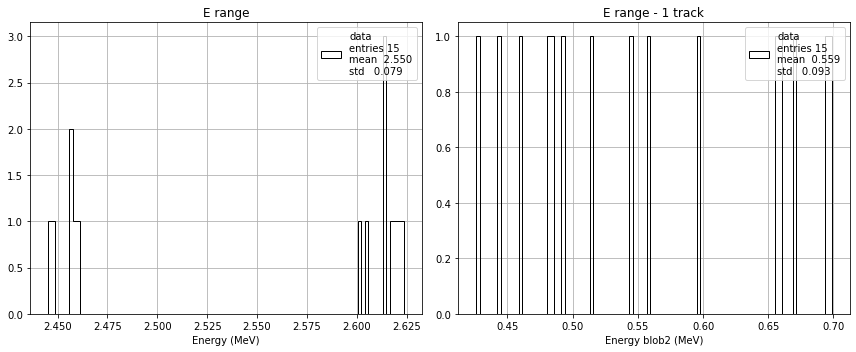

In [12]:
plt_fanal(data, sel)

## Estimate the number of signal events

### Estimate the number of expected events

In [13]:
from ana.collpars import nevts_Bi, nevts_Tl

## Estimate the number of events

estimated events :   4.24,   1.69,   9.07,
expected  events :   5.19,   2.60,   8.13,


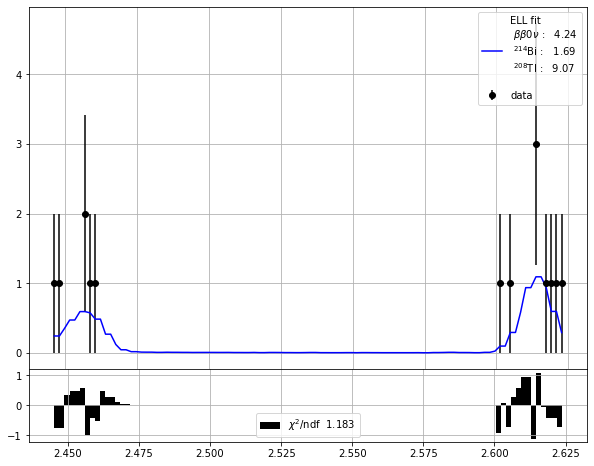

In [14]:
nevts = (10, nevts_Bi.value, nevts_Tl.value)
result, ene, ell, effs = fn.ana_experiment(data, mcs, nevts, level_data = 2)
ns_est  = result.x
ns_exp = [ni * eff[0] for ni, eff in zip(nevts, effs)]
print('estimated events :', *['{:6.2f},'.format(ni) for ni in ns_est])
print('expected  events :', *['{:6.2f},'.format(ni) for ni in ns_exp])

fn.plot_fit_ell(ene, ns_est, ell.pdf)

## Estimate the half-time

In [15]:
from ana.collpars import acc_bb, exposure
# get the bb-mc selection and efficiency
mcsel      = fn.selection(mcbb, varnames, varranges)
eff, ueff  = ut.efficiency(mcsel) 

nevts_bb_RoI  = ns_est[0]
tau           = fn.half_life(nevts_bb_RoI, exposure, acc_bb * eff)

print('number of bb0nu events : {:6.3f}'.format(nevts_bb_RoI))
print('exposure               : ', exposure, ' kg y')
print('signal efficiency      : {:6.3f} +- {:6.3f}'.format(eff, ueff))
print('bb0nu half-life        : {:6.2e} y '.format(tau))
#TODO: uncertainties

number of bb0nu events :  4.236
exposure               :  500  kg y
signal efficiency      :  0.519 +-  0.002
bb0nu half-life        : 1.34e+26 y 
